In [1]:
import argparse
import yaml
from models import MIAFEx
from utils import chestCTforMIAFEx
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.optim as optim
from utils import save_model, load_model_state

In [3]:
yaml_path = '/home/anhkhoa/Medical-Image-Classification/src/config/miafex_config.yaml'

def load_yaml(path):

    with open(path, 'r') as file:
        data = yaml.safe_load(file)
    return data


config = load_yaml(yaml_path)
train_set = chestCTforMIAFEx(config["data"]["path"], "train", config["data"]["img_size"])
dev_set = chestCTforMIAFEx(config["data"]["path"], "valid", config["data"]["img_size"])
test_set = chestCTforMIAFEx(config["data"]["path"], "test", config["data"]["img_size"])

train_loader = DataLoader(train_set, batch_size=config["data"]["batch_size"], shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=config["data"]["batch_size"], shuffle=False)
test_loader = DataLoader(test_set, batch_size=config["data"]["batch_size"], shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

viT = MIAFEx(
    d_model = config["model"]["d_model"],
    encoder_layers= config["model"]["encoder_layers"],
    patch_size= config["model"]["patch_size"],
    num_classes= config["model"]["num_classes"],
).to(device)

criterion = nn.CrossEntropyLoss()
num_epochs = config["model"]["epochs"]

optimizer = optim.Adam(viT.parameters(), lr=config["adam"]["lr"])

model, optimizer = load_model_state(viT, optimizer, config["model"]["save_path"])

Model state loaded successfully from /home/anhkhoa/Medical-Image-Classification/src/save_path/miafex


In [5]:
features = []
labels = []

for x_batch, y_batch in train_loader:
    with torch.no_grad():
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        R = model.extract_features(x_batch)
        features.append(R.cpu())
        labels.append(y_batch.cpu())

features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()

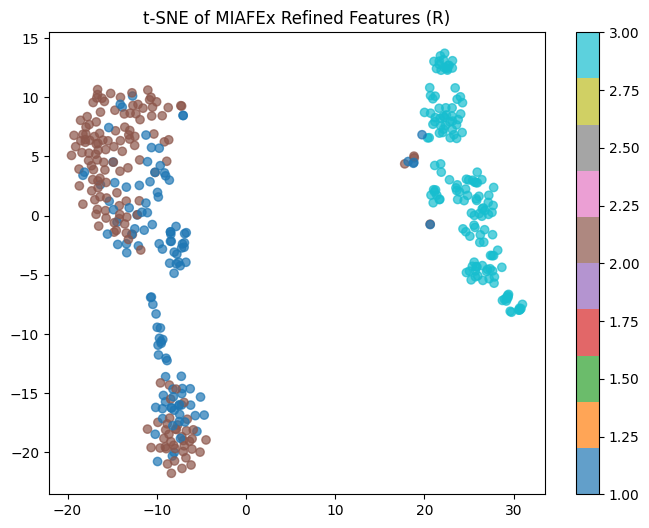

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("t-SNE of MIAFEx Refined Features (R)")
plt.show()
